

Le jeu de données Churn d'Orange Telecom, qui comprend des données d'activité client nettoyées (caractéristiques), ainsi qu'une étiquette de désabonnement indiquant si un client a annulé son abonnement, sera utilisé pour développer des modèles prédictifs. Deux ensembles de données sont disponibles ici : les jeux de données churn-80 et churn-20 peuvent être téléchargés.

Les deux ensembles proviennent du même lot, mais ont été séparés selon un ratio de 80/20. Comme davantage de données sont souvent souhaitables pour développer des modèles de machine learning, utilisons l'ensemble le plus grand (churn-80) pour l'entraînement et la validation croisée, et l'ensemble le plus petit (churn-20) pour les tests finaux et l'évaluation des performances du modèle.

In [ ]:
# Librairies de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Analysis Libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import MinMaxScaler,StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report,confusion_matrix,mean_squared_error,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV, RandomizedSearchCV
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import scipy.stats as stats
from scipy.stats import shapiro, levene, kruskal, ttest_ind, f_oneway
from tabulate import tabulate

# Machine Learning Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

#Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
2024-06-21 21:44:31.561146: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-21 21:44:31.561248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-21 21:44:31.849182: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 55)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

***Chargement des données*** 

In [ ]:
df20 = pd.read_csv("C:\Users\papid\mes_projets\churn-bigml-20.csv")
df80 = pd.read_csv("C:\Users\papid\mes_projets\churn-bigml-80.csv")
df = pd.concat([df20, df80], ignore_index=True)
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,LA,117,408,No,No,0,184.500,97,31.370,351.600,80,29.890,215.800,90,9.710,8.700,4,2.350,1,False
1,IN,65,415,No,No,0,129.100,137,21.950,228.500,83,19.420,208.800,111,9.400,12.700,6,3.430,4,True
2,NY,161,415,No,No,0,332.900,67,56.590,317.800,97,27.010,160.600,128,7.230,5.400,9,1.460,4,True
3,SC,111,415,No,No,0,110.400,103,18.770,137.300,102,11.670,189.600,105,8.530,7.700,6,2.080,2,False
4,HI,49,510,No,No,0,119.300,117,20.280,215.100,109,18.280,178.700,90,8.040,11.100,1,3.000,1,False


FEATURES


***
State:

Type: Categorical (string)
Description: Indique l'état dans lequel réside le client. Cet attribut peut être utile pour une analyse régionale des taux de désabonnement.


Account length:

Type: Integer
Description: La durée de la relation du client avec le fournisseur de services télécom, mesurée en mois. Cela peut être un indicateur de fidélité et de satisfaction du client.


Area code:

Type: Integer
Description: L'indicatif régional associé au numéro de téléphone du client. Il est souvent utilisé pour segmenter les clients géographiquement.


International plan:

Type: Categorical (string)
Description: Indique si le client dispose d'un forfait international (par exemple, "oui" ou "non"). Cette caractéristique pourrait influencer les habitudes d'utilisation et les coûts.


Voice mail plan:

Type: Categorical (string)
Description: Indique si le client dispose d'un forfait de messagerie vocale (par exemple, "oui" ou "non"). Cette caractéristique peut être liée à l'engagement du client et à ses préférences de service.


Number vmail messages:

Type: Integer
Description: Le nombre de messages vocaux laissés par le client. Cette caractéristique peut refléter l'engagement du client et son utilisation des services de messagerie vocale.


Total day minutes:

Type: Float
Description: Le nombre total de minutes utilisées lors des appels de jour. C'est une métrique clé pour comprendre le comportement d'appel du client pendant les heures de pointe.


Total day calls:

Type: Integer
Description: Le nombre total d'appels de jour effectués par le client. Cette caractéristique aide à analyser la fréquence des appels pendant la journée.


Total day charge:

Type: Float
Description: Les frais totaux pour les appels de jour. C'est le coût supporté par le client pour l'utilisation de la journée.


Total eve minutes:

Type: Float
Description: Le nombre total de minutes utilisées lors des appels du soir. Cette caractéristique est cruciale pour comprendre les habitudes d'utilisation en dehors des heures de pointe.


Total eve calls:

Type: Integer
Description: Le nombre total d'appels du soir effectués par le client. Cela reflète la fréquence des appels effectués le soir.


Total eve charge:

Type: Float
Description: Les frais totaux pour les appels du soir. Cela montre le coût supporté par le client pour l'utilisation en soirée.


Total night minutes:

Type: Float
Description: Le nombre total de minutes utilisées lors des appels de nuit. Les appels de nuit sont souvent moins chers, donc cette caractéristique est utile pour l'analyse des coûts.


Total night calls:

Type: Integer
Description: Le nombre total d'appels de nuit effectués par le client. Cela peut aider à analyser les habitudes d'appel pendant les heures nocturnes.

Total night charge:
Type: Float
Description: Les frais totaux pour les appels de nuit. Cela indique la dépense supportée par le client pour l'utilisation nocturne.


Total intl minutes:

Type: Float
Description: Le nombre total de minutes utilisées pour les appels internationaux. C'est essentiel pour analyser le comportement d'appel international.


Total intl calls:

Type: Integer
Description: Le nombre total d'appels internationaux effectués par le client. Cette caractéristique aide à comprendre l'étendue des appels internationaux.
Total intl charge:

Type: Float
Description: Les frais totaux pour les appels internationaux. Cela montre le coût associé aux appels internationaux.


Customer service calls:

Type: Integer
Description: Le nombre d'appels effectués par le client au service client. Un nombre élevé d'appels au service peut indiquer des problèmes avec le service ou une insatisfaction.


Churn:

Type: Categorical (string)
Description: Indique si le client s'est désabonné ("oui" ou "non"). C'est la variable cible pour le modèle de prédiction du désabonnement.***


***Analyse du dataset***

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   3333 non-null   object 
 1   Account length          3333 non-null   int64  
 2   Area code               3333 non-null   int64  
 3   International plan      3333 non-null   object 
 4   Voice mail plan         3333 non-null   object 
 5   Number vmail messages   3333 non-null   int64  
 6   Total day minutes       3333 non-null   float64
 7   Total day calls         3333 non-null   int64  
 8   Total day charge        3333 non-null   float64
 9   Total eve minutes       3333 non-null   float64
 10  Total eve calls         3333 non-null   int64  
 11  Total eve charge        3333 non-null   float64
 12  Total night minutes     3333 non-null   float64
 13  Total night calls       3333 non-null   int64  
 14  Total night charge      3333 non-null   

In [5]:
df.isnull().sum()

State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total night charge        0
Total intl minutes        0
Total intl calls          0
Total intl charge         0
Customer service calls    0
Churn                     0
dtype: int64

In [6]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 3333
Variables: 20
cat_cols: 4
num_cols: 15
cat_but_car: 1
num_but_cat: 2


In [7]:
cat_cols, num_cols, cat_but_car

(['International plan', 'Voice mail plan', 'Area code', 'Churn'],
 ['Account length',
  'Number vmail messages',
  'Total day minutes',
  'Total day calls',
  'Total day charge',
  'Total eve minutes',
  'Total eve calls',
  'Total eve charge',
  'Total night minutes',
  'Total night calls',
  'Total night charge',
  'Total intl minutes',
  'Total intl calls',
  'Total intl charge',
  'Customer service calls'],
 ['State'])

In [8]:
df[['International plan', 'Voice mail plan', 'Area code', 'Churn']]

,International plan,Voice mail plan,Area code,Churn
0,No,No,408,False
1,No,No,415,True
2,No,No,415,True
3,No,No,415,False
4,No,No,510,False
...,...,...,...,...
3328,No,No,415,False
3329,No,Yes,415,False
3330,No,No,415,False
3331,No,No,510,False


In [9]:
df["International plan"] = df["International plan"].replace({"No": 0, "Yes": 1})
df["Voice mail plan"] = df["Voice mail plan"].replace({"No": 0, "Yes": 1})
df["Churn"] = df["Churn"].astype(int)

In [10]:
df = df.drop(["State"], axis=1)

In [11]:
df[['International plan', 'Voice mail plan', 'Area code', 'Churn']]

,International plan,Voice mail plan,Area code,Churn
0,0,0,408,0
1,0,0,415,1
2,0,0,415,1
3,0,0,415,0
4,0,0,510,0
...,...,...,...,...
3328,0,0,415,0
3329,0,1,415,0
3330,0,0,415,0
3331,0,0,510,0


In [12]:
df.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,117,408,0,0,0,184.500,97,31.370,351.600,80,29.890,215.800,90,9.710,8.700,4,2.350,1,0
1,65,415,0,0,0,129.100,137,21.950,228.500,83,19.420,208.800,111,9.400,12.700,6,3.430,4,1
2,161,415,0,0,0,332.900,67,56.590,317.800,97,27.010,160.600,128,7.230,5.400,9,1.460,4,1
3,111,415,0,0,0,110.400,103,18.770,137.300,102,11.670,189.600,105,8.530,7.700,6,2.080,2,0
4,49,510,0,0,0,119.300,117,20.280,215.100,109,18.280,178.700,90,8.040,11.100,1,3.000,1,0


In [13]:
df["Area code"].unique()

array([408, 415, 510])

***VISUALISATION***

                    International plan  Ratio
International plan                           
0                                 3010 90.309
1                                  323  9.691


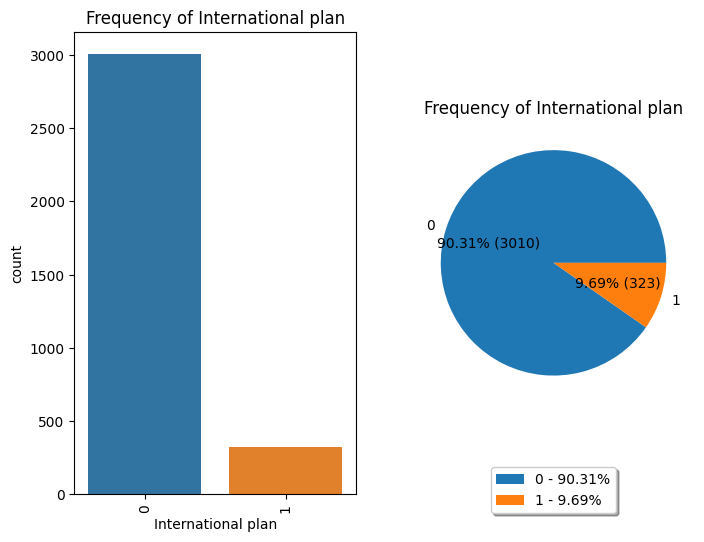

                 Voice mail plan  Ratio
Voice mail plan                        
0                           2411 72.337
1                            922 27.663


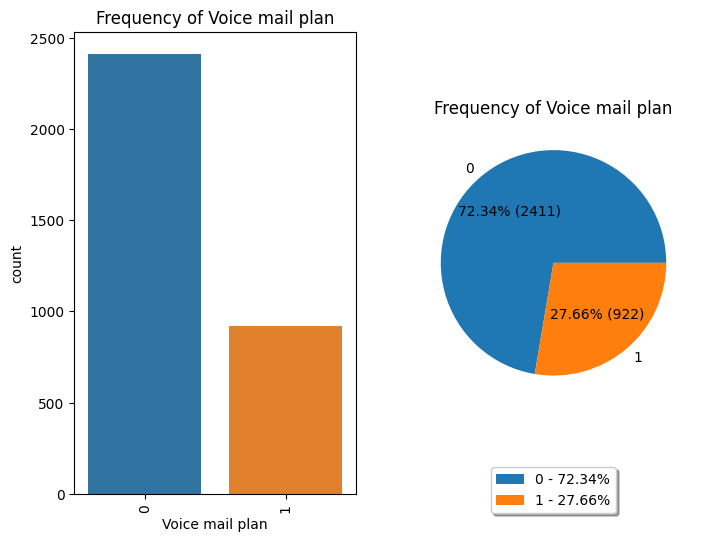

           Area code  Ratio
Area code                  
415             1655 49.655
510              840 25.203
408              838 25.143


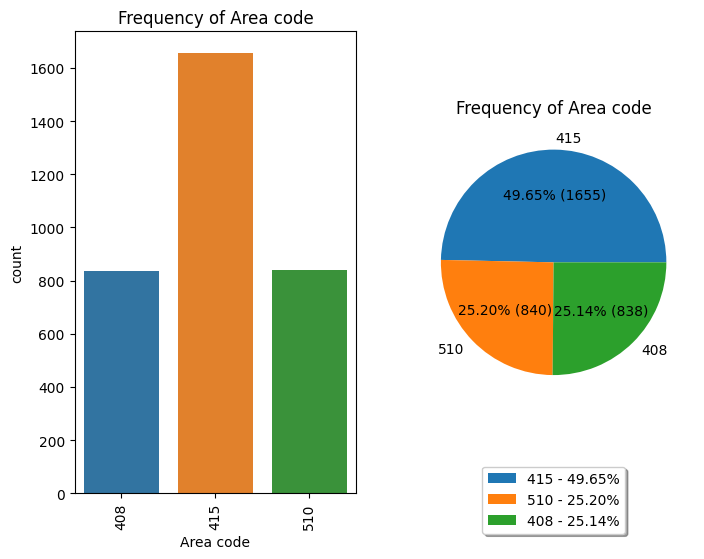

       Churn  Ratio
Churn              
0       2850 85.509
1        483 14.491


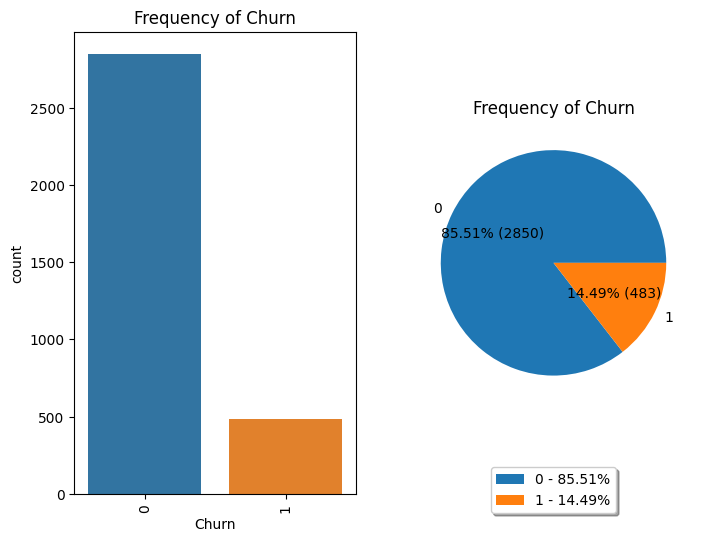

In [ ]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(8, 6))
        plt.subplot(1, 2, 1)
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.title("Frequence de" + col_name)
        plt.xticks(rotation=90)

        plt.subplot(1, 2, 2)
        values = dataframe[col_name].value_counts()
        plt.pie(x=values, labels=values.index, autopct=lambda p: '{:.2f}% ({:.0f})'.format(p, p/100 * sum(values)))
        plt.title("Frequence de " + col_name)
        plt.legend(labels=['{} - {:.2f}%'.format(index, value/sum(values)*100) for index, value in zip(values.index, values)],
                   loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=1)
        plt.show(block=True)

for col in cat_cols:
    cat_summary(df, col, True)

count   3333.000
mean     101.065
std       39.822
min        1.000
5%        35.000
10%       50.000
20%       67.000
30%       80.000
40%       91.000
50%      101.000
60%      111.000
70%      122.000
80%      134.000
90%      152.000
95%      167.000
99%      195.000
max      243.000
Name: Account length, dtype: float64


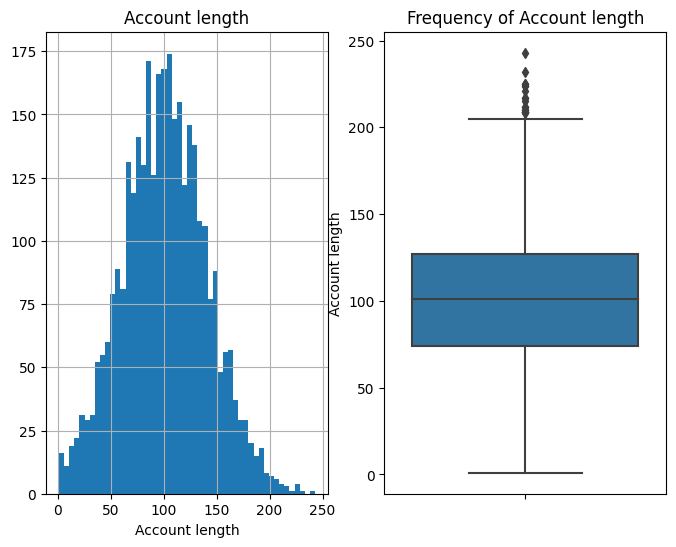

#####################################
count   3333.000
mean       8.099
std       13.688
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%       25.000
90%       32.000
95%       36.000
99%       43.000
max       51.000
Name: Number vmail messages, dtype: float64


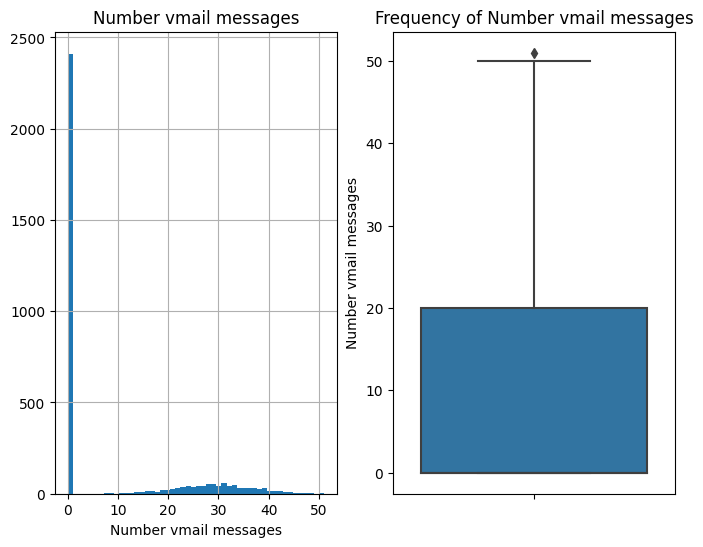

#####################################
count   3333.000
mean     179.775
std       54.467
min        0.000
5%        89.920
10%      110.320
20%      134.740
30%      151.100
40%      165.680
50%      179.400
60%      194.000
70%      208.740
80%      224.760
90%      249.580
95%      270.740
99%      305.168
max      350.800
Name: Total day minutes, dtype: float64


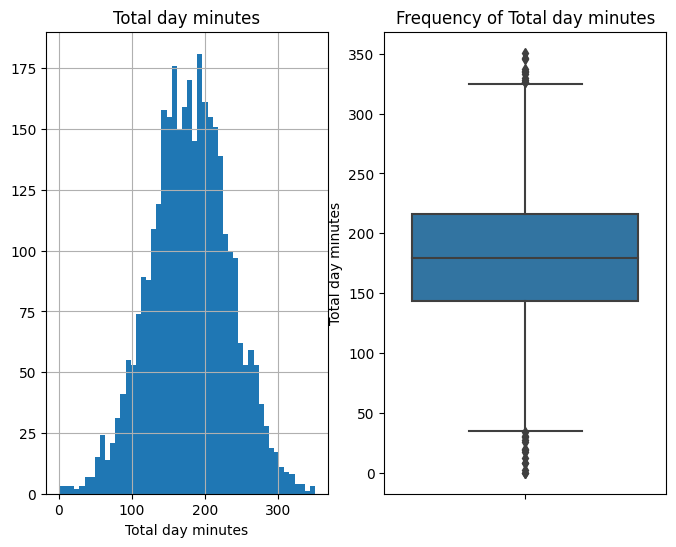

#####################################
count   3333.000
mean     100.436
std       20.069
min        0.000
5%        67.000
10%       74.200
20%       84.000
30%       90.000
40%       96.000
50%      101.000
60%      106.000
70%      111.000
80%      117.000
90%      126.000
95%      133.000
99%      146.000
max      165.000
Name: Total day calls, dtype: float64


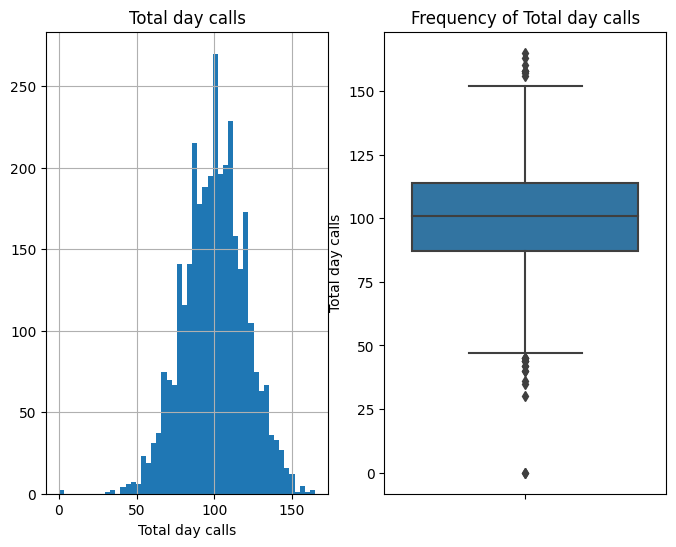

#####################################
count   3333.000
mean      30.562
std        9.259
min        0.000
5%        15.288
10%       18.754
20%       22.908
30%       25.690
40%       28.166
50%       30.500
60%       32.980
70%       35.488
80%       38.212
90%       42.428
95%       46.028
99%       51.877
max       59.640
Name: Total day charge, dtype: float64


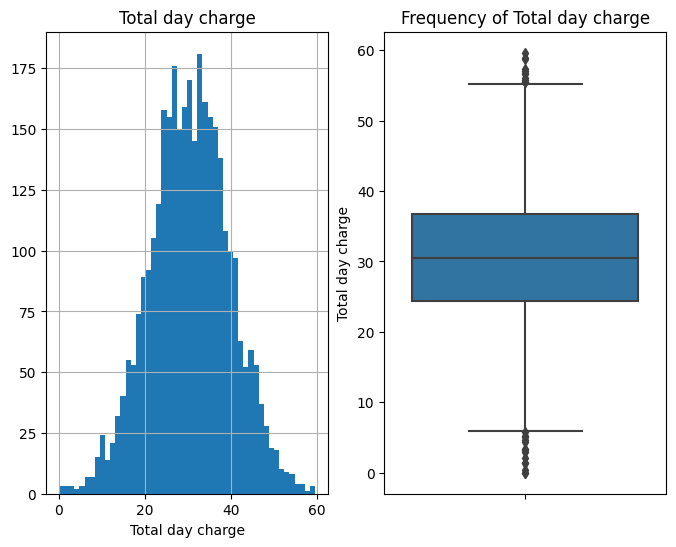

#####################################
count   3333.000
mean     200.980
std       50.714
min        0.000
5%       118.800
10%      136.720
20%      158.940
30%      173.300
40%      188.000
50%      201.400
60%      213.440
70%      226.740
80%      244.400
90%      265.800
95%      284.300
99%      318.936
max      363.700
Name: Total eve minutes, dtype: float64


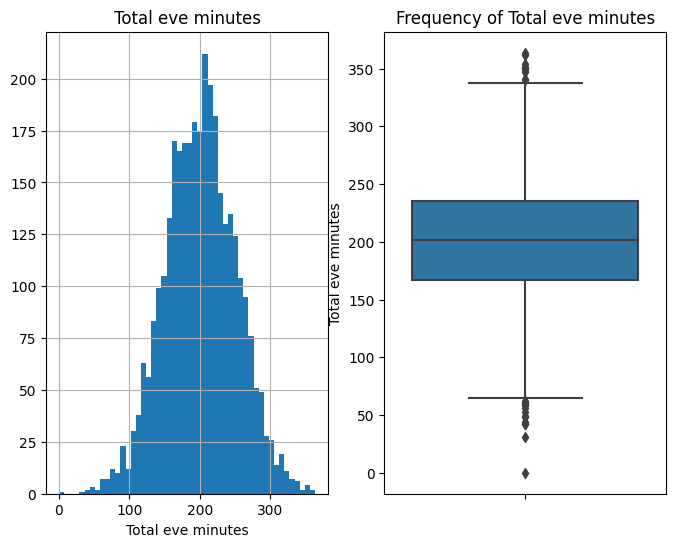

#####################################
count   3333.000
mean     100.114
std       19.923
min        0.000
5%        67.000
10%       75.000
20%       84.000
30%       90.000
40%       95.000
50%      100.000
60%      105.000
70%      111.000
80%      117.000
90%      125.000
95%      133.000
99%      147.000
max      170.000
Name: Total eve calls, dtype: float64


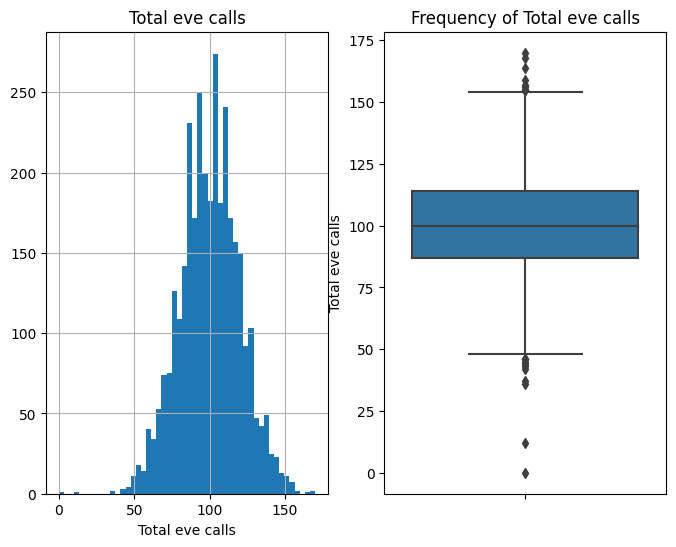

#####################################
count   3333.000
mean      17.084
std        4.311
min        0.000
5%        10.100
10%       11.622
20%       13.514
30%       14.730
40%       15.980
50%       17.120
60%       18.144
70%       19.274
80%       20.770
90%       22.590
95%       24.170
99%       27.114
max       30.910
Name: Total eve charge, dtype: float64


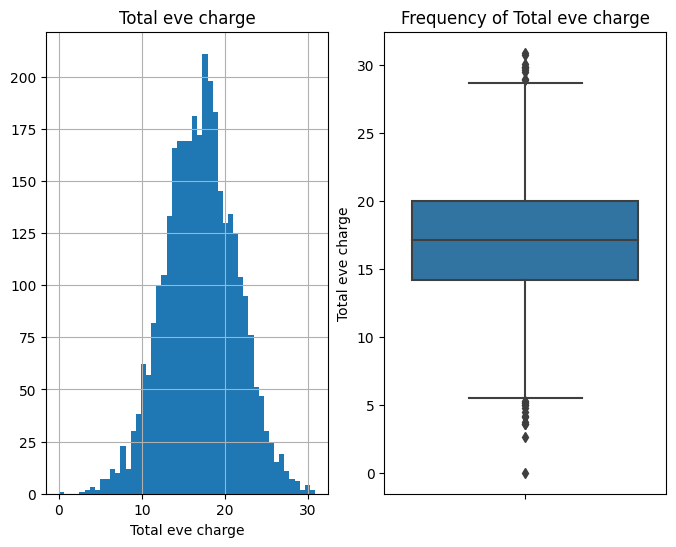

#####################################
count   3333.000
mean     200.872
std       50.574
min       23.200
5%       118.180
10%      136.340
20%      158.600
30%      174.000
40%      188.200
50%      201.200
60%      214.000
70%      227.540
80%      243.900
90%      264.200
95%      282.840
99%      317.448
max      395.000
Name: Total night minutes, dtype: float64


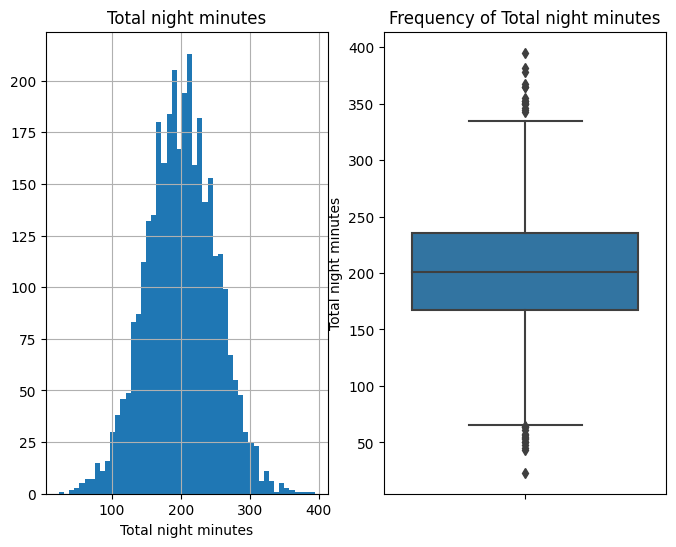

#####################################
count   3333.000
mean     100.108
std       19.569
min       33.000
5%        68.000
10%       75.000
20%       83.000
30%       90.000
40%       95.000
50%      100.000
60%      105.000
70%      110.000
80%      117.000
90%      125.000
95%      132.000
99%      146.680
max      175.000
Name: Total night calls, dtype: float64


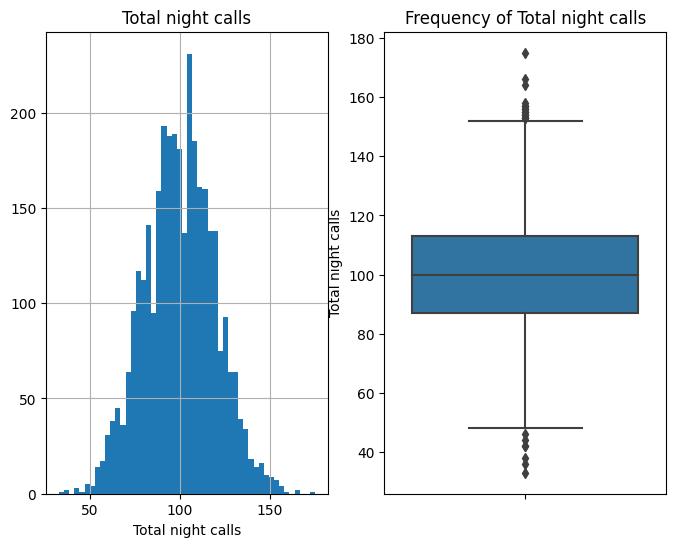

#####################################
count   3333.000
mean       9.039
std        2.276
min        1.040
5%         5.316
10%        6.132
20%        7.140
30%        7.830
40%        8.470
50%        9.050
60%        9.630
70%       10.240
80%       10.980
90%       11.890
95%       12.730
99%       14.284
max       17.770
Name: Total night charge, dtype: float64


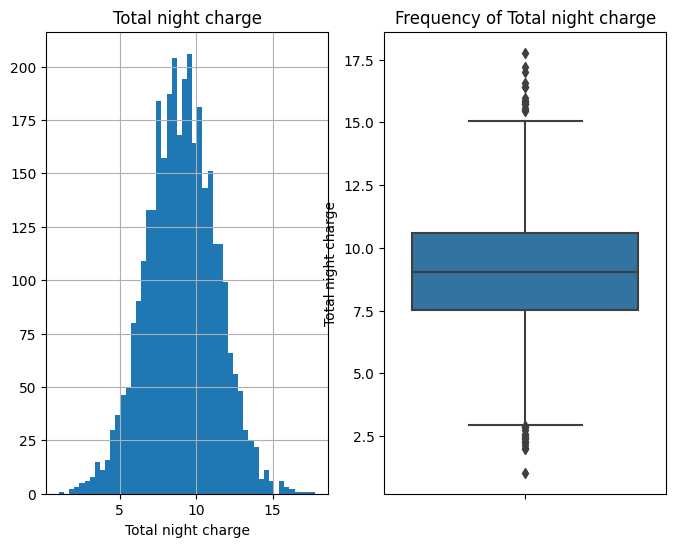

#####################################
count   3333.000
mean      10.237
std        2.792
min        0.000
5%         5.700
10%        6.700
20%        8.000
30%        8.900
40%        9.700
50%       10.300
60%       11.000
70%       11.700
80%       12.500
90%       13.700
95%       14.700
99%       16.668
max       20.000
Name: Total intl minutes, dtype: float64


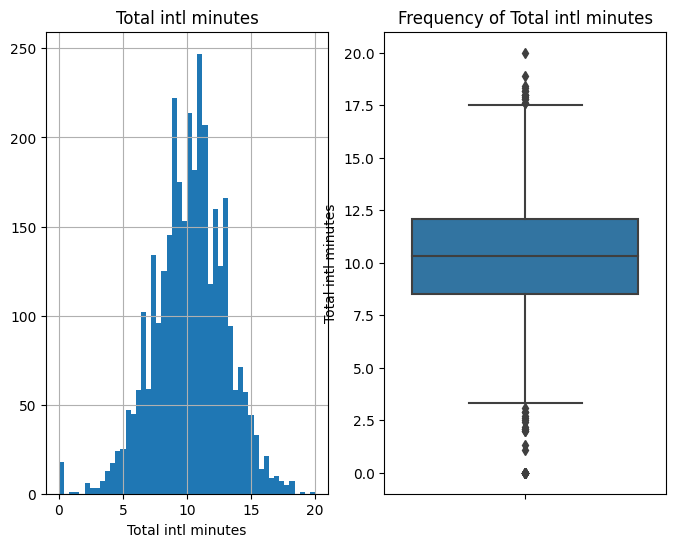

#####################################
count   3333.000
mean       4.479
std        2.461
min        0.000
5%         1.000
10%        2.000
20%        2.400
30%        3.000
40%        3.000
50%        4.000
60%        5.000
70%        5.000
80%        6.000
90%        8.000
95%        9.000
99%       13.000
max       20.000
Name: Total intl calls, dtype: float64


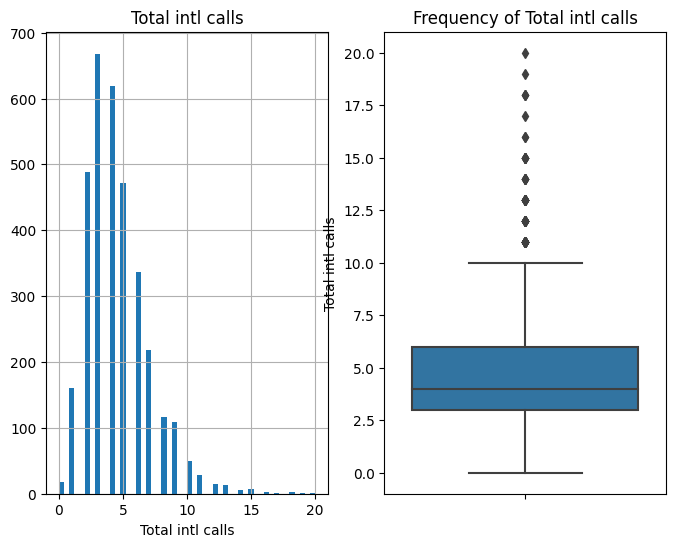

#####################################
count   3333.000
mean       2.765
std        0.754
min        0.000
5%         1.540
10%        1.810
20%        2.160
30%        2.400
40%        2.620
50%        2.780
60%        2.970
70%        3.160
80%        3.380
90%        3.700
95%        3.970
99%        4.500
max        5.400
Name: Total intl charge, dtype: float64


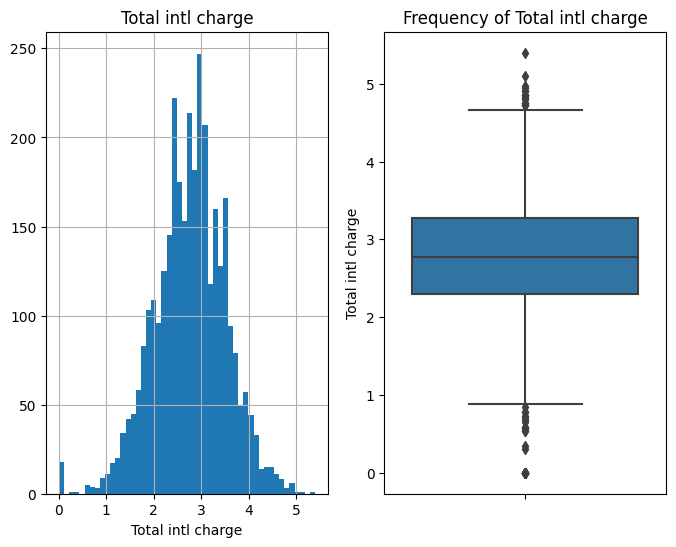

#####################################
count   3333.000
mean       1.563
std        1.315
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        1.000
40%        1.000
50%        1.000
60%        2.000
70%        2.000
80%        3.000
90%        3.000
95%        4.000
99%        6.000
max        9.000
Name: Customer service calls, dtype: float64


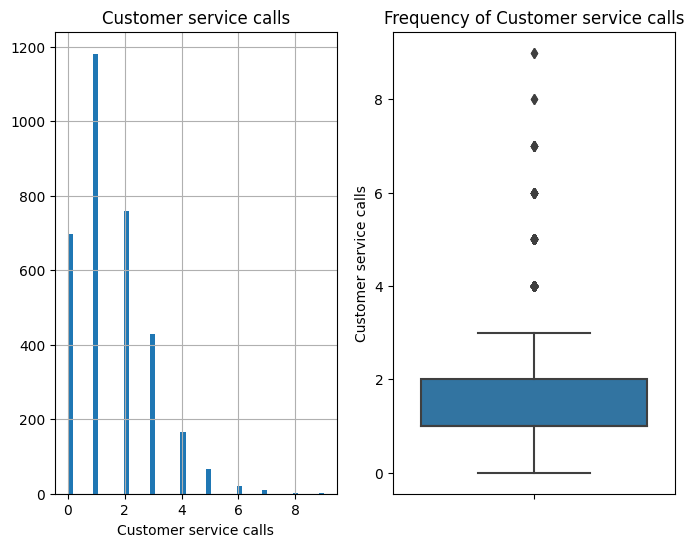

#####################################


In [15]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
            fig, axs = plt.subplots(1, 2, figsize=(8, 6))
            plt.subplot(1, 2, 1)
            dataframe[numerical_col].hist(bins=50)
            plt.xlabel(numerical_col)
            plt.title(numerical_col)

            plt.subplot(1, 2, 2)
            sns.boxplot(y=numerical_col, data=dataframe)
            plt.title("Frequency of " + numerical_col)
            plt.xticks(rotation=90)

            plt.show(block=True)      

    print("#####################################")

for col in num_cols:
    num_summary(df, col, plot=True)

In [16]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in num_cols:
    target_summary_with_num(df, "Churn", col)

       Account length
Churn                
0             100.794
1             102.665


       Number vmail messages
Churn                       
0                      8.605
1                      5.116


       Total day minutes
Churn                   
0                175.176
1                206.914


       Total day calls
Churn                 
0              100.283
1              101.335


       Total day charge
Churn                  
0                29.780
1                35.176


       Total eve minutes
Churn                   
0                199.043
1                212.410


       Total eve calls
Churn                 
0              100.039
1              100.561


       Total eve charge
Churn                  
0                16.919
1                18.055


       Total night minutes
Churn                     
0                  200.133
1                  205.232


       Total night calls
Churn                   
0                100.058
1                10

# <div style="border-radius:10px; border:#5E5772 solid; padding: 12px; background-color: #6999; font-size:100%; font-family:Comic Sans MS; font-family:Comic Sans MS; text-align:center"> FIRST ML WITHOUT EDA </div>

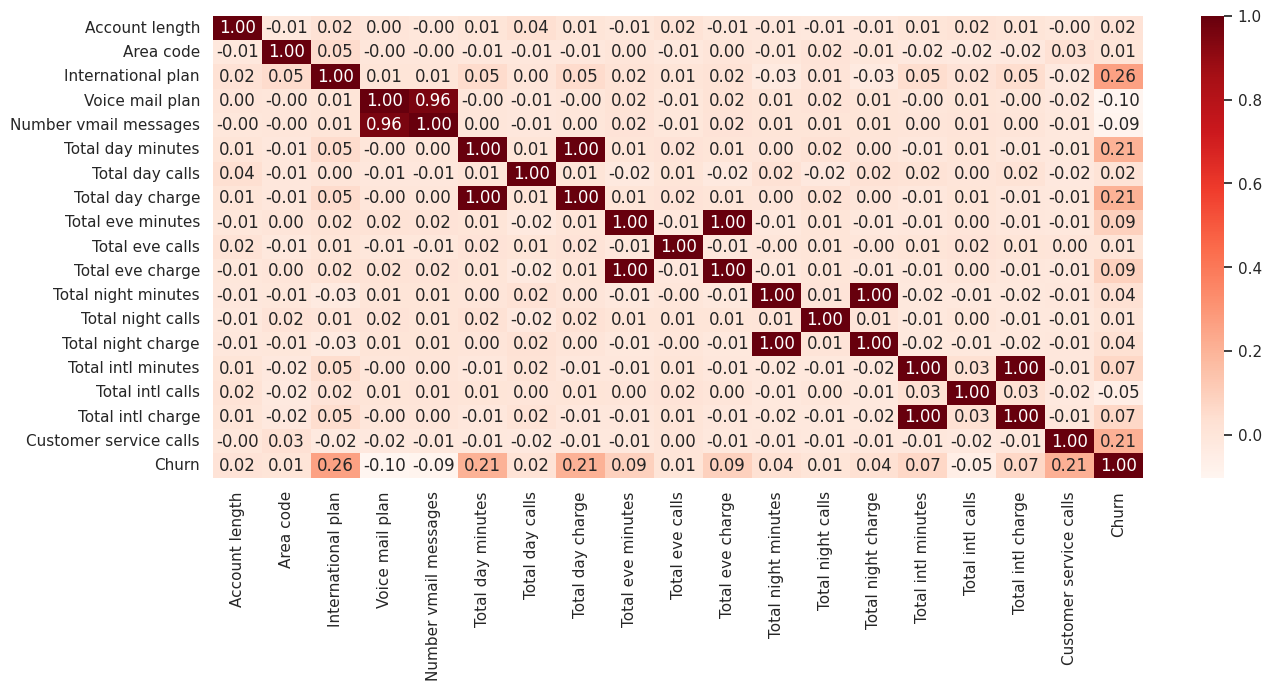

In [17]:
corr = df.corr()
sns.set(rc={'figure.figsize': (15, 6)})
sns.heatmap(corr, cmap="Reds", annot=True, fmt=".2f")
plt.show()

In [18]:
y = df["Churn"]
X = df.drop("Churn", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

rf_model = RandomForestClassifier(random_state=42).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [19]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.94
Recall: 0.893
Precision: 0.71
F1: 0.79
Auc: 0.92


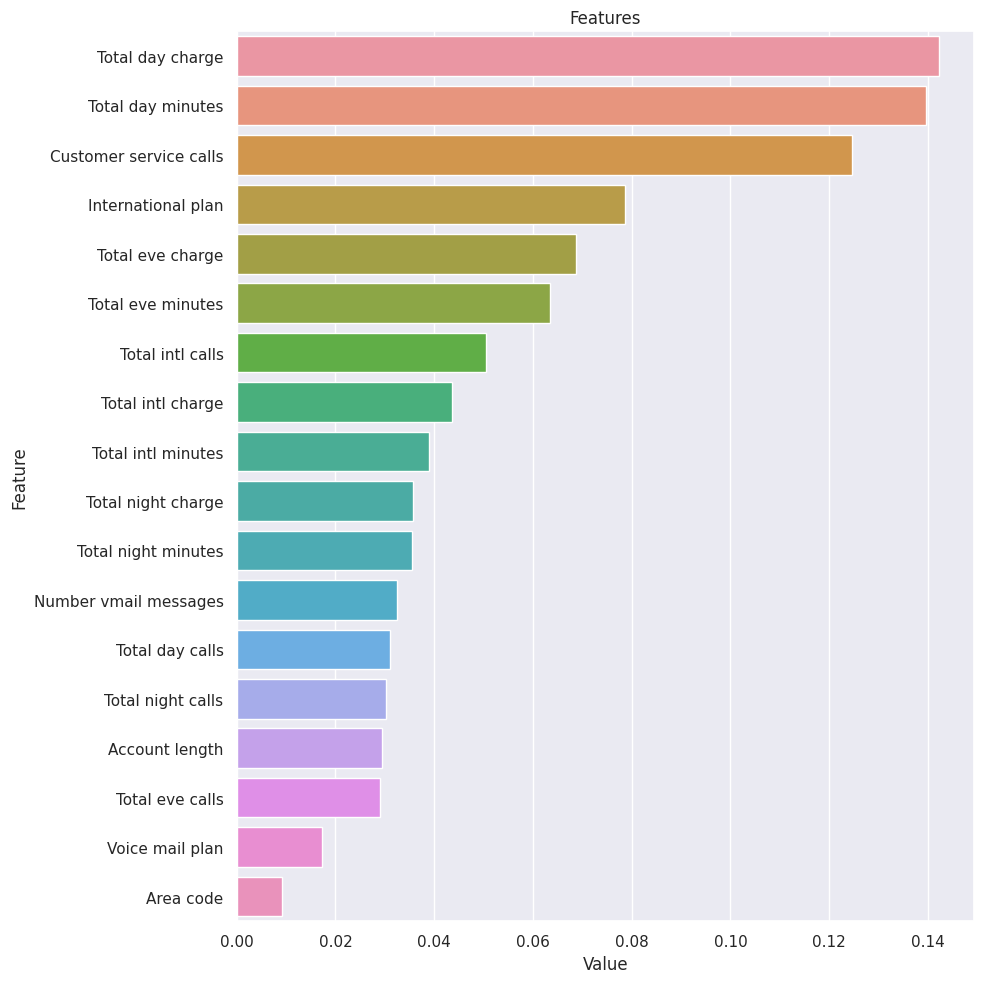

In [20]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_model, X)

# <div style="border-radius:10px; border:#5E5772 solid; padding: 12px; background-color: #6999; font-size:100%; font-family:Comic Sans MS; font-family:Comic Sans MS; text-align:center"> FEATURE EXTRACTION </div>

In [21]:
def outlier_thresholds(dataframe, col_name, q1=0.10, q3=0.90):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [22]:
for col in df[num_cols].columns:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

Account length False
Number vmail messages False
Total day minutes False
Total day calls False
Total day charge False
Total eve minutes False
Total eve calls False
Total eve charge False
Total night minutes False
Total night calls False
Total night charge False
Total intl minutes False
Total intl calls True
Total intl charge False
Customer service calls True


In [23]:
for col in df[num_cols].columns:
    print(col, check_outlier(df, col))

Account length False
Number vmail messages False
Total day minutes False
Total day calls False
Total day charge False
Total eve minutes False
Total eve calls False
Total eve charge False
Total night minutes False
Total night calls False
Total night charge False
Total intl minutes False
Total intl calls True
Total intl charge False
Customer service calls True


In [24]:
df.columns = [col.upper() for col in df.columns]

df.head()

,ACCOUNT LENGTH,AREA CODE,INTERNATIONAL PLAN,VOICE MAIL PLAN,NUMBER VMAIL MESSAGES,TOTAL DAY MINUTES,TOTAL DAY CALLS,TOTAL DAY CHARGE,TOTAL EVE MINUTES,TOTAL EVE CALLS,TOTAL EVE CHARGE,TOTAL NIGHT MINUTES,TOTAL NIGHT CALLS,TOTAL NIGHT CHARGE,TOTAL INTL MINUTES,TOTAL INTL CALLS,TOTAL INTL CHARGE,CUSTOMER SERVICE CALLS,CHURN
0,117,408,0,0,0,184.500,97,31.370,351.600,80,29.890,215.800,90,9.710,8.700,4,2.350,1,0
1,65,415,0,0,0,129.100,137,21.950,228.500,83,19.420,208.800,111,9.400,12.700,6,3.430,4,1
2,161,415,0,0,0,332.900,67,56.590,317.800,97,27.010,160.600,128,7.230,5.400,9,1.460,4,1
3,111,415,0,0,0,110.400,103,18.770,137.300,102,11.670,189.600,105,8.530,7.700,6,2.080,2,0
4,49,510,0,0,0,119.300,117,20.280,215.100,109,18.280,178.700,90,8.040,11.100,1,3.000,1,0


In [25]:
df['NEW_TOTALMINUTES'] = df['TOTAL DAY MINUTES'] + df['TOTAL EVE MINUTES'] + df['TOTAL NIGHT MINUTES']

df['NEW_TOTALCHARGES'] = df['TOTAL DAY CHARGE'] + df['TOTAL EVE CHARGE'] + df['TOTAL NIGHT CHARGE']

df['NEW_TOTALCALLS'] = df['TOTAL DAY CALLS'] + df['TOTAL EVE CALLS'] + df['TOTAL NIGHT CALLS']

df['NEW_AVGDAYCALLDURATION'] = df['TOTAL DAY MINUTES'] / df['TOTAL DAY CALLS']
df['NEW_AVGEVECALLDURATION'] = df['TOTAL EVE MINUTES'] / df['TOTAL EVE CALLS']
df['NEW_AVGNIGHTCALLDURATION'] = df['TOTAL NIGHT MINUTES'] / df['TOTAL NIGHT CALLS']

df['NEW_AVGINTLCHARGEPERMINUTE'] = df['TOTAL INTL CHARGE'] / df['TOTAL INTL MINUTES']

df['NEW_AVGDAYCHARGEPERCALL'] = df['TOTAL DAY CHARGE'] / df['TOTAL DAY CALLS']
df['NEW_AVGEVECHARGEPERCALL'] = df['TOTAL EVE CHARGE'] / df['TOTAL EVE CALLS']
df['NEW_AVGNIGHTCHARGEPERCALL'] = df['TOTAL NIGHT CHARGE'] / df['TOTAL NIGHT CALLS']

df['NEW_AVGINTLCHARGEPERCALL'] = df['TOTAL INTL CHARGE'] / df['TOTAL INTL CALLS']

df['NEW_AVGVMAILCHARGEPERMESSAGE'] = df['TOTAL DAY CHARGE'] / df['NUMBER VMAIL MESSAGES']

df['NEW_AVGSERVICECALLCHARGE'] = df['TOTAL DAY CHARGE'] / df['CUSTOMER SERVICE CALLS']

In [26]:
df = pd.get_dummies(df, columns=["AREA CODE"], drop_first=True)
df[["AREA CODE_415","AREA CODE_510"]] = df[["AREA CODE_415","AREA CODE_510"]].astype(int)

In [27]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 3333
Variables: 33
cat_cols: 5
num_cols: 28
cat_but_car: 0
num_but_cat: 5


In [28]:
df.head()

,ACCOUNT LENGTH,INTERNATIONAL PLAN,VOICE MAIL PLAN,NUMBER VMAIL MESSAGES,TOTAL DAY MINUTES,TOTAL DAY CALLS,TOTAL DAY CHARGE,TOTAL EVE MINUTES,TOTAL EVE CALLS,TOTAL EVE CHARGE,TOTAL NIGHT MINUTES,TOTAL NIGHT CALLS,TOTAL NIGHT CHARGE,TOTAL INTL MINUTES,TOTAL INTL CALLS,TOTAL INTL CHARGE,CUSTOMER SERVICE CALLS,CHURN,NEW_TOTALMINUTES,NEW_TOTALCHARGES,NEW_TOTALCALLS,NEW_AVGDAYCALLDURATION,NEW_AVGEVECALLDURATION,NEW_AVGNIGHTCALLDURATION,NEW_AVGINTLCHARGEPERMINUTE,NEW_AVGDAYCHARGEPERCALL,NEW_AVGEVECHARGEPERCALL,NEW_AVGNIGHTCHARGEPERCALL,NEW_AVGINTLCHARGEPERCALL,NEW_AVGVMAILCHARGEPERMESSAGE,NEW_AVGSERVICECALLCHARGE,AREA CODE_415,AREA CODE_510
0,117,0,0,0,184.500,97,31.370,351.600,80,29.890,215.800,90,9.710,8.700,4,2.350,1,0,751.900,70.970,267,1.902,4.395,2.398,0.270,0.323,0.374,0.108,0.588,inf,31.370,0,0
1,65,0,0,0,129.100,137,21.950,228.500,83,19.420,208.800,111,9.400,12.700,6,3.430,4,1,566.400,50.770,331,0.942,2.753,1.881,0.270,0.160,0.234,0.085,0.572,inf,5.487,1,0
2,161,0,0,0,332.900,67,56.590,317.800,97,27.010,160.600,128,7.230,5.400,9,1.460,4,1,811.300,90.830,292,4.969,3.276,1.255,0.270,0.845,0.278,0.056,0.162,inf,14.148,1,0
3,111,0,0,0,110.400,103,18.770,137.300,102,11.670,189.600,105,8.530,7.700,6,2.080,2,0,437.300,38.970,310,1.072,1.346,1.806,0.270,0.182,0.114,0.081,0.347,inf,9.385,1,0
4,49,0,0,0,119.300,117,20.280,215.100,109,18.280,178.700,90,8.040,11.100,1,3.000,1,0,513.100,46.600,316,1.020,1.973,1.986,0.270,0.173,0.168,0.089,3.000,inf,20.280,0,1


In [29]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

df.fillna(df.mean(), inplace=True)

In [30]:
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df.head()

,ACCOUNT LENGTH,INTERNATIONAL PLAN,VOICE MAIL PLAN,NUMBER VMAIL MESSAGES,TOTAL DAY MINUTES,TOTAL DAY CALLS,TOTAL DAY CHARGE,TOTAL EVE MINUTES,TOTAL EVE CALLS,TOTAL EVE CHARGE,TOTAL NIGHT MINUTES,TOTAL NIGHT CALLS,TOTAL NIGHT CHARGE,TOTAL INTL MINUTES,TOTAL INTL CALLS,TOTAL INTL CHARGE,CUSTOMER SERVICE CALLS,CHURN,NEW_TOTALMINUTES,NEW_TOTALCHARGES,NEW_TOTALCALLS,NEW_AVGDAYCALLDURATION,NEW_AVGEVECALLDURATION,NEW_AVGNIGHTCALLDURATION,NEW_AVGINTLCHARGEPERMINUTE,NEW_AVGDAYCHARGEPERCALL,NEW_AVGEVECHARGEPERCALL,NEW_AVGNIGHTCHARGEPERCALL,NEW_AVGINTLCHARGEPERCALL,NEW_AVGVMAILCHARGEPERMESSAGE,NEW_AVGSERVICECALLCHARGE,AREA CODE_415,AREA CODE_510
0,0.479,0,0,0.000,0.526,0.588,0.526,0.967,0.471,0.967,0.518,0.401,0.518,0.435,0.200,0.435,0.111,0,0.792,0.703,0.356,0.261,0.269,0.315,0.425,0.261,0.269,0.315,0.109,0.186,0.526,0,0
1,0.264,0,0,0.000,0.368,0.830,0.368,0.628,0.488,0.628,0.499,0.549,0.500,0.635,0.300,0.635,0.444,1,0.484,0.424,0.644,0.128,0.162,0.240,0.417,0.128,0.162,0.240,0.106,0.186,0.092,1,0
2,0.661,0,0,0.000,0.949,0.406,0.949,0.874,0.571,0.874,0.370,0.669,0.370,0.270,0.450,0.270,0.444,1,0.891,0.976,0.468,0.687,0.196,0.149,0.481,0.687,0.196,0.149,0.021,0.186,0.237,1,0
3,0.455,0,0,0.000,0.315,0.624,0.315,0.378,0.600,0.378,0.448,0.507,0.448,0.385,0.300,0.385,0.222,0,0.269,0.262,0.550,0.146,0.070,0.229,0.429,0.146,0.070,0.229,0.059,0.186,0.157,1,0
4,0.198,0,0,0.000,0.340,0.709,0.340,0.591,0.641,0.591,0.418,0.401,0.418,0.555,0.050,0.556,0.111,0,0.395,0.367,0.577,0.138,0.111,0.255,0.459,0.138,0.111,0.255,0.606,0.186,0.340,0,1


# <div style="border-radius:10px; border:#5E5772 solid; padding: 12px; background-color: #6999; font-size:100%; font-family:Comic Sans MS; font-family:Comic Sans MS; text-align:center"> STATISTICAL ANALYSIS </div>

In [31]:
df.head()

,ACCOUNT LENGTH,INTERNATIONAL PLAN,VOICE MAIL PLAN,NUMBER VMAIL MESSAGES,TOTAL DAY MINUTES,TOTAL DAY CALLS,TOTAL DAY CHARGE,TOTAL EVE MINUTES,TOTAL EVE CALLS,TOTAL EVE CHARGE,TOTAL NIGHT MINUTES,TOTAL NIGHT CALLS,TOTAL NIGHT CHARGE,TOTAL INTL MINUTES,TOTAL INTL CALLS,TOTAL INTL CHARGE,CUSTOMER SERVICE CALLS,CHURN,NEW_TOTALMINUTES,NEW_TOTALCHARGES,NEW_TOTALCALLS,NEW_AVGDAYCALLDURATION,NEW_AVGEVECALLDURATION,NEW_AVGNIGHTCALLDURATION,NEW_AVGINTLCHARGEPERMINUTE,NEW_AVGDAYCHARGEPERCALL,NEW_AVGEVECHARGEPERCALL,NEW_AVGNIGHTCHARGEPERCALL,NEW_AVGINTLCHARGEPERCALL,NEW_AVGVMAILCHARGEPERMESSAGE,NEW_AVGSERVICECALLCHARGE,AREA CODE_415,AREA CODE_510
0,0.479,0,0,0.000,0.526,0.588,0.526,0.967,0.471,0.967,0.518,0.401,0.518,0.435,0.200,0.435,0.111,0,0.792,0.703,0.356,0.261,0.269,0.315,0.425,0.261,0.269,0.315,0.109,0.186,0.526,0,0
1,0.264,0,0,0.000,0.368,0.830,0.368,0.628,0.488,0.628,0.499,0.549,0.500,0.635,0.300,0.635,0.444,1,0.484,0.424,0.644,0.128,0.162,0.240,0.417,0.128,0.162,0.240,0.106,0.186,0.092,1,0
2,0.661,0,0,0.000,0.949,0.406,0.949,0.874,0.571,0.874,0.370,0.669,0.370,0.270,0.450,0.270,0.444,1,0.891,0.976,0.468,0.687,0.196,0.149,0.481,0.687,0.196,0.149,0.021,0.186,0.237,1,0
3,0.455,0,0,0.000,0.315,0.624,0.315,0.378,0.600,0.378,0.448,0.507,0.448,0.385,0.300,0.385,0.222,0,0.269,0.262,0.550,0.146,0.070,0.229,0.429,0.146,0.070,0.229,0.059,0.186,0.157,1,0
4,0.198,0,0,0.000,0.340,0.709,0.340,0.591,0.641,0.591,0.418,0.401,0.418,0.555,0.050,0.556,0.111,0,0.395,0.367,0.577,0.138,0.111,0.255,0.459,0.138,0.111,0.255,0.606,0.186,0.340,0,1


In [32]:
# Shapiro-Wilk test for normality (each values)
for group in list(df["AREA CODE_415"].unique()):
    statistic, pvalue = shapiro(df.loc[df["AREA CODE_415"] == group, "CHURN"])
    print(f"Shapiro-Wilk test for {group}: statistic = {statistic:.3f}, p-value = {pvalue:.3f}")

Shapiro-Wilk test for 0: statistic = 0.422, p-value = 0.000
Shapiro-Wilk test for 1: statistic = 0.415, p-value = 0.000


In [33]:
# Shapiro-Wilk test for normality (each values)
for group in list(df["AREA CODE_510"].unique()):
    statistic, pvalue = shapiro(df.loc[df["AREA CODE_510"] == group, "CHURN"])
    print(f"Shapiro-Wilk test for {group}: statistic = {statistic:.3f}, p-value = {pvalue:.3f}")

Shapiro-Wilk test for 0: statistic = 0.417, p-value = 0.000
Shapiro-Wilk test for 1: statistic = 0.425, p-value = 0.000


In [34]:
h_statistic, pvalue = kruskal(df.loc[df["AREA CODE_510"] == 0, "CHURN"],
                                            df.loc[df["AREA CODE_510"] == 1, "CHURN"])
print(f"Kruskal-Wallis test: H-statistic = {h_statistic:.3f}, p-value = {pvalue:.3f}")

Kruskal-Wallis test: H-statistic = 0.137, p-value = 0.711


In [35]:
h_statistic, pvalue = kruskal(df.loc[df["AREA CODE_415"] == 0, "CHURN"],
                                            df.loc[df["AREA CODE_415"] == 1, "CHURN"])
print(f"Kruskal-Wallis test: H-statistic = {h_statistic:.3f}, p-value = {pvalue:.3f}")

Kruskal-Wallis test: H-statistic = 0.142, p-value = 0.706


# <div style="border-radius:10px; border:#5E5772 solid; padding: 12px; background-color: #6999; font-size:100%; font-family:Comic Sans MS; font-family:Comic Sans MS; text-align:center"> ML MODELLING </div>

In [36]:
y = df["CHURN"]
X = df.drop("CHURN", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [37]:
X_train

,ACCOUNT LENGTH,INTERNATIONAL PLAN,VOICE MAIL PLAN,NUMBER VMAIL MESSAGES,TOTAL DAY MINUTES,TOTAL DAY CALLS,TOTAL DAY CHARGE,TOTAL EVE MINUTES,TOTAL EVE CALLS,TOTAL EVE CHARGE,TOTAL NIGHT MINUTES,TOTAL NIGHT CALLS,TOTAL NIGHT CHARGE,TOTAL INTL MINUTES,TOTAL INTL CALLS,TOTAL INTL CHARGE,CUSTOMER SERVICE CALLS,NEW_TOTALMINUTES,NEW_TOTALCHARGES,NEW_TOTALCALLS,NEW_AVGDAYCALLDURATION,NEW_AVGEVECALLDURATION,NEW_AVGNIGHTCALLDURATION,NEW_AVGINTLCHARGEPERMINUTE,NEW_AVGDAYCHARGEPERCALL,NEW_AVGEVECHARGEPERCALL,NEW_AVGNIGHTCHARGEPERCALL,NEW_AVGINTLCHARGEPERCALL,NEW_AVGVMAILCHARGEPERMESSAGE,NEW_AVGSERVICECALLCHARGE,AREA CODE_415,AREA CODE_510
367,0.483,0,1,0.765,0.261,0.758,0.261,0.605,0.665,0.605,0.554,0.465,0.554,0.635,0.400,0.635,0.222,0.441,0.339,0.671,0.098,0.109,0.302,0.417,0.099,0.109,0.303,0.076,0.064,0.130,1,0
3103,0.496,0,1,0.549,0.314,0.570,0.314,0.389,0.447,0.389,0.576,0.380,0.576,0.320,0.150,0.320,0.222,0.355,0.295,0.311,0.159,0.104,0.363,0.469,0.159,0.104,0.363,0.107,0.109,0.157,0,1
549,0.331,0,0,0.000,0.926,0.291,0.926,0.650,0.482,0.650,0.442,0.317,0.442,0.655,0.250,0.656,0.000,0.787,0.878,0.090,0.936,0.170,0.316,0.450,0.936,0.170,0.316,0.134,0.186,0.342,1,0
2531,0.174,0,1,0.686,0.571,0.636,0.571,0.672,0.518,0.672,0.495,0.451,0.495,0.580,0.200,0.580,0.333,0.626,0.608,0.459,0.262,0.163,0.277,0.362,0.262,0.163,0.277,0.149,0.160,0.190,0,0
2378,0.508,0,0,0.000,0.508,0.618,0.508,0.646,0.706,0.646,0.582,0.606,0.583,0.545,0.050,0.544,0.333,0.628,0.566,0.689,0.240,0.110,0.259,0.339,0.240,0.110,0.259,0.594,0.186,0.169,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,0.401,0,1,0.745,0.609,0.370,0.609,0.696,0.612,0.696,0.496,0.282,0.497,0.535,0.250,0.535,0.222,0.663,0.650,0.225,0.483,0.141,0.380,0.421,0.483,0.141,0.380,0.107,0.157,0.305,1,0
1130,0.368,0,1,0.588,0.524,0.461,0.524,0.632,0.559,0.632,0.325,0.641,0.325,0.385,0.150,0.385,0.111,0.469,0.514,0.482,0.333,0.140,0.136,0.429,0.333,0.140,0.136,0.131,0.171,0.524,0,0
1294,0.554,0,1,0.431,0.562,0.685,0.562,0.713,0.559,0.713,0.300,0.718,0.300,0.730,0.250,0.730,0.222,0.525,0.574,0.698,0.239,0.160,0.112,0.370,0.239,0.160,0.112,0.150,0.252,0.281,1,0
860,0.376,1,0,0.000,0.493,0.848,0.493,0.661,0.618,0.661,0.565,0.592,0.565,0.450,0.250,0.450,0.111,0.617,0.556,0.784,0.169,0.132,0.256,0.400,0.169,0.132,0.256,0.088,0.186,0.493,1,0


In [38]:
unique, counts = np.unique(y_test, return_counts=True)
for value, count in zip(unique, counts):
    print(f"Value: {value}, Count: {count}")

Value: 0, Count: 704
Value: 1, Count: 130


In [39]:
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.95
Recall: 0.979
Precision: 0.72
F1: 0.83
Auc: 0.97


    Value                       Feature
18  0.147              NEW_TOTALCHARGES
16  0.079        CUSTOMER SERVICE CALLS
6   0.066              TOTAL DAY CHARGE
17  0.062              NEW_TOTALMINUTES
1   0.061            INTERNATIONAL PLAN
4   0.060             TOTAL DAY MINUTES
29  0.059      NEW_AVGSERVICECALLCHARGE
27  0.033      NEW_AVGINTLCHARGEPERCALL
3   0.031         NUMBER VMAIL MESSAGES
13  0.027            TOTAL INTL MINUTES
15  0.025             TOTAL INTL CHARGE
9   0.024              TOTAL EVE CHARGE
14  0.024              TOTAL INTL CALLS
28  0.023  NEW_AVGVMAILCHARGEPERMESSAGE
24  0.023       NEW_AVGDAYCHARGEPERCALL
2   0.023               VOICE MAIL PLAN
20  0.022        NEW_AVGDAYCALLDURATION
7   0.022             TOTAL EVE MINUTES
5   0.018               TOTAL DAY CALLS
25  0.018       NEW_AVGEVECHARGEPERCALL
12  0.017            TOTAL NIGHT CHARGE
21  0.016        NEW_AVGEVECALLDURATION
10  0.015           TOTAL NIGHT MINUTES
0   0.015                ACCOUNT LENGTH


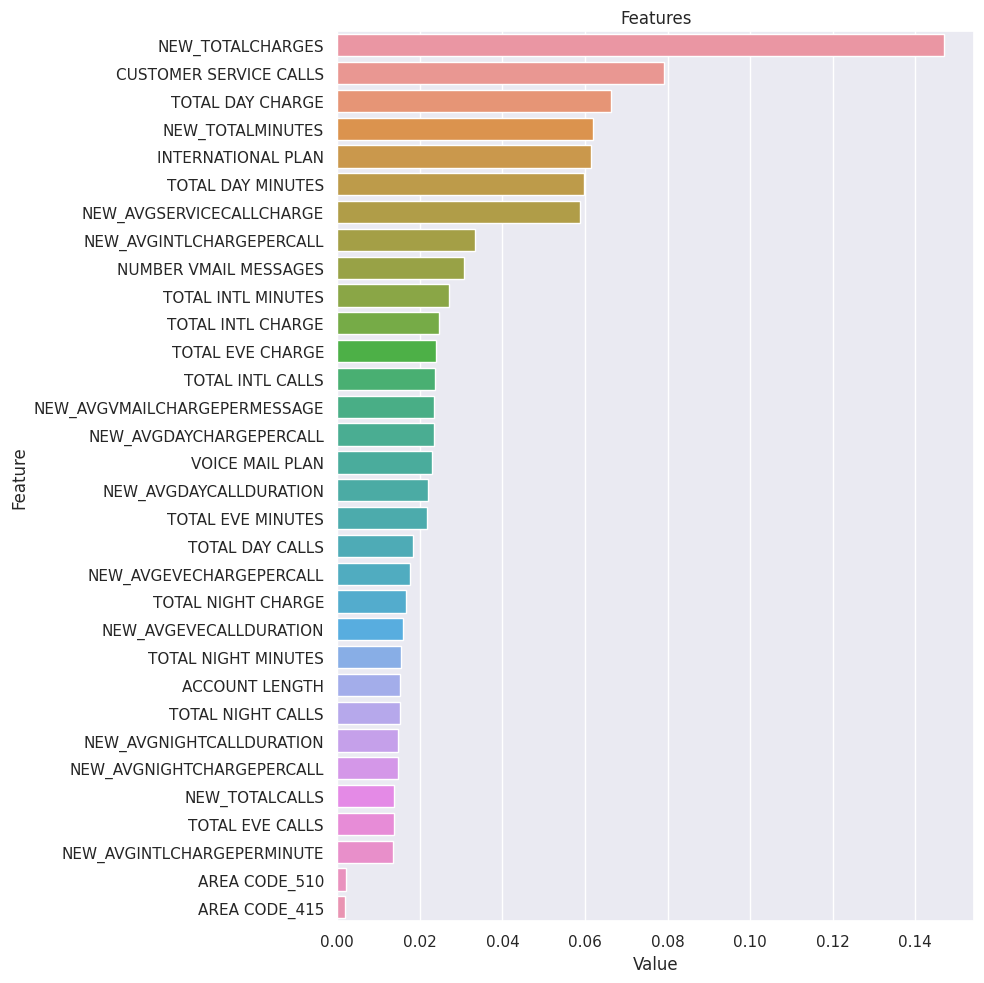

In [40]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value",ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_model, X)

In [41]:
models = [('LR', LogisticRegression()),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier()),
          ('RF', RandomForestClassifier(n_estimators=200)),
          ('SVC', SVC()),
          ('GBM', GradientBoostingClassifier(n_estimators=200, learning_rate=0.06)),
          ("XGBoost", XGBClassifier(learning_rate=0.06)),
          ("LightGBM", LGBMClassifier(learning_rate=0.06, verbose=-1)),
          ("CatBoost", CatBoostClassifier(learning_rate=0.06,verbose=False))]

In [42]:
acclist=[]
for name, model in models:
    acc = np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy"))
    acclist.append([name,acc])
    print(f"ACC: {round(acc, 4)} ({name}) ")

ACC: 0.8655 (LR) 
ACC: 0.8896 (KNN) 
ACC: 0.9472 (CART) 
ACC: 0.9648 (RF) 
ACC: 0.898 (SVC) 
ACC: 0.9728 (GBM) 
ACC: 0.9728 (XGBoost) 
ACC: 0.9732 (LightGBM) 
ACC: 0.974 (CatBoost) 


## LightGBM

In [43]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)

lgbm_accuracy=round(accuracy_score(y_test,y_pred), 4)*100
lgbm_accuracy

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 353, number of negative: 2146
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5444
[LightGBM] [Info] Number of data points in the train set: 2499, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.141257 -> initscore=-1.804893
[LightGBM] [Info] Start training from score -1.804893


95.44

In [44]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       704
           1       0.98      0.72      0.83       130

    accuracy                           0.95       834
   macro avg       0.97      0.86      0.90       834
weighted avg       0.96      0.95      0.95       834



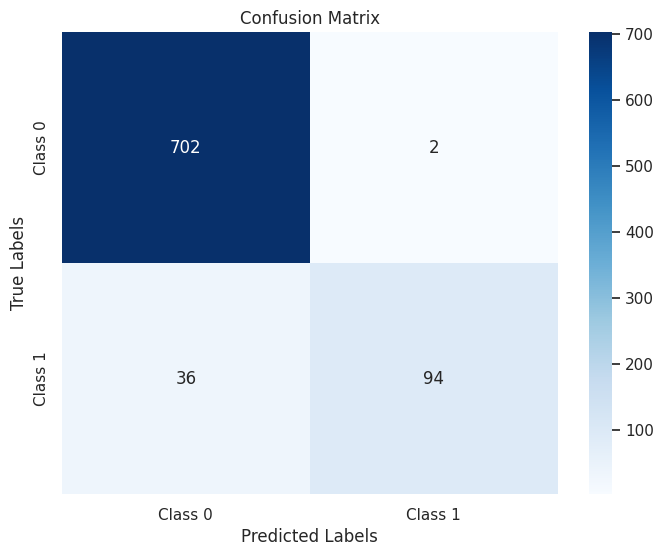

In [45]:
cm = confusion_matrix(y_test, y_pred)

class_labels = ['Class 0', 'Class 1']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Catboost

In [46]:
"""catboost_model = CatBoostClassifier(verbose=False, random_state=42)
catboost_params = {
    "learning_rate": [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08, 0.1],
    "n_estimators": [100, 200, 400, 500, 800, 1000, 1500],
    "depth": [4, 6, 8, 10],
    "l2_leaf_reg": [1, 3, 5, 7, 9]}
catboost_random_search = RandomizedSearchCV(catboost_model,
                                            catboost_params,
                                            n_iter=100,
                                            cv=3,
                                            n_jobs=-1,
                                            verbose=1,
                                            random_state=42,
                                            scoring='accuracy').fit(X_train, y_train)"""

'catboost_model = CatBoostClassifier(verbose=False, random_state=42)\ncatboost_params = {\n    "learning_rate": [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08, 0.1],\n    "n_estimators": [100, 200, 400, 500, 800, 1000, 1500],\n    "depth": [4, 6, 8, 10],\n    "l2_leaf_reg": [1, 3, 5, 7, 9]}\ncatboost_random_search = RandomizedSearchCV(catboost_model,\n                                            catboost_params,\n                                            n_iter=100,\n                                            cv=3,\n                                            n_jobs=-1,\n                                            verbose=1,\n                                            random_state=42,\n                                            scoring=\'accuracy\').fit(X_train, y_train)'

In [47]:
"""print("Best parameters:", catboost_random_search.best_params_)
print("Best Scores:", catboost_random_search.best_score_)"""

'print("Best parameters:", catboost_random_search.best_params_)\nprint("Best Scores:", catboost_random_search.best_score_)'

In [48]:
"""best_model = catboost_random_search.best_estimator_
y_pred_cat = best_model.predict(X_test)

cat_accuracy=round(accuracy_score(y_test,y_pred), 4)*100
cat_accuracy"""

'best_model = catboost_random_search.best_estimator_\ny_pred_cat = best_model.predict(X_test)\n\ncat_accuracy=round(accuracy_score(y_test,y_pred), 4)*100\ncat_accuracy'

In [49]:
best_params = {'n_estimators': 400, 'learning_rate': 0.03, 'l2_leaf_reg': 5, 'depth': 4}

In [50]:
best_model = CatBoostClassifier(**best_params, verbose=False, random_state=42)
best_model.fit(X_train, y_train)
y_pred_cat = best_model.predict(X_test)

cat_accuracy=round(accuracy_score(y_test,y_pred_cat), 4)*100
cat_accuracy

96.64

In [51]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       704
           1       0.98      0.72      0.83       130

    accuracy                           0.95       834
   macro avg       0.97      0.86      0.90       834
weighted avg       0.96      0.95      0.95       834



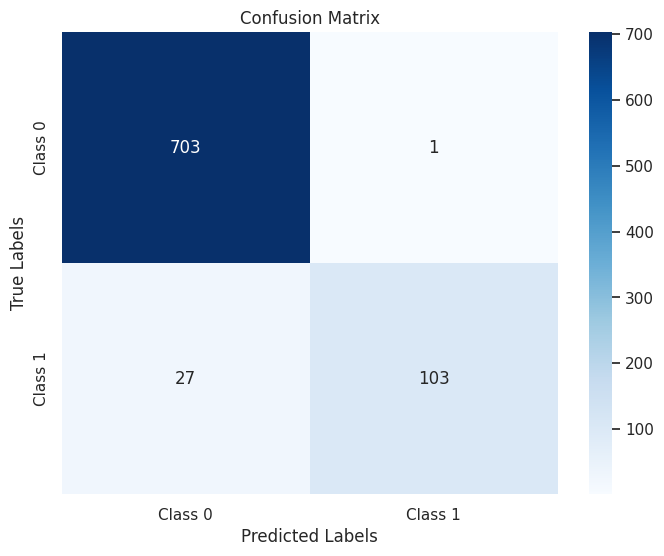

In [52]:
cm = confusion_matrix(y_test, y_pred_cat)

class_labels = ['Class 0', 'Class 1']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# <div style="border-radius:10px; border:#5E5772 solid; padding: 12px; background-color: #6999; font-size:100%; font-family:Comic Sans MS; font-family:Comic Sans MS; text-align:center"> ANN </div>

In [53]:
X_train.shape[1]

32

In [54]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, input_shape=(X_train.shape[1],), activation="tanh", kernel_regularizer=tf.keras.regularizers.l2(0.004)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(64, activation="tanh", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(32, activation="tanh", kernel_regularizer=tf.keras.regularizers.l2(0.002)),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(16, activation="tanh", kernel_regularizer=tf.keras.regularizers.l2(0.003)),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(8, activation="tanh", kernel_regularizer=tf.keras.regularizers.l2(0.002)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,233 (59.50 KB)

 Trainable params: 15,233 (59.50 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,
                    batch_size=64,
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/100
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7214 - loss: 1.0435  

I0000 00:00:1719006366.811681     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 223ms/step - accuracy: 0.7620 - loss: 0.9979 - val_accuracy: 0.8441 - val_loss: 0.9757
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8371 - loss: 0.8482 - val_accuracy: 0.8441 - val_loss: 0.8783
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8500 - loss: 0.8264 - val_accuracy: 0.8441 - val_loss: 0.8198
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8490 - loss: 0.7723 - val_accuracy: 0.8465 - val_loss: 0.7458
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8519 - loss: 0.7437 - val_accuracy: 0.8477 - val_loss: 0.7398
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8534 - loss: 0.7270 - val_accuracy: 0.8597 - val_loss: 0.6560
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8515 - loss: 0.6870 - val_accuracy: 0.8549 - val_loss: 0.6307
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8691 - loss: 0.6394 - val_accuracy: 0.8585 - val_loss: 

In [56]:
loss_and_metrics = model.evaluate(X_test, y_test)
print(loss_and_metrics)
print('Loss = ',loss_and_metrics[0])
print('Accuracy = ',loss_and_metrics[1])

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8626 - loss: 0.3709   
[0.37625110149383545, 0.853717029094696]
Loss =  0.37625110149383545
Accuracy =  0.853717029094696


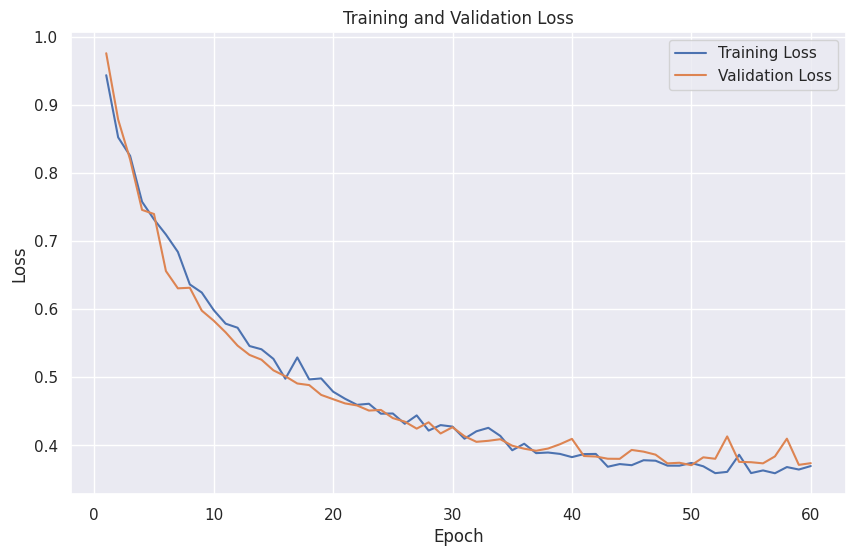

In [57]:
plt.figure(figsize=(10, 6))

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [58]:
predicted = model.predict(X_test)
predicted = tf.squeeze(predicted)
predicted = np.array([1 if x >= 0.5 else 0 for x in predicted])
actual = np.array(y_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [59]:
predicted[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

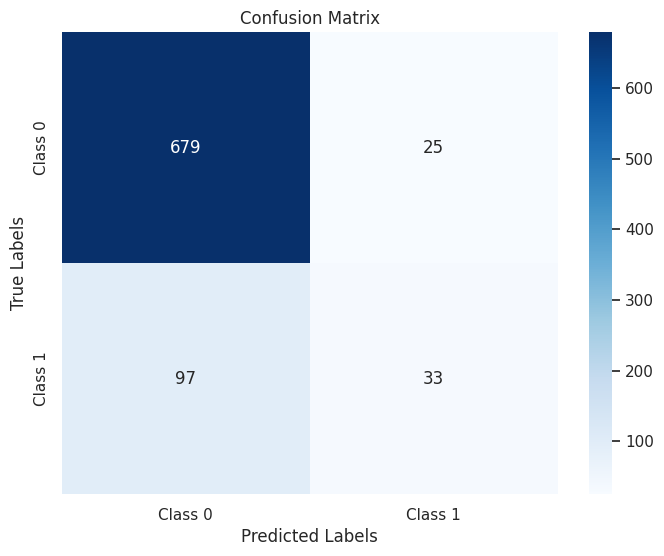

In [60]:
cm = confusion_matrix(y_test, predicted)

class_labels = ['Class 0', 'Class 1']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# <div style="border-radius:10px; border:#5E5772 solid; padding: 12px; background-color: #6999; font-size:100%; font-family:Comic Sans MS; font-family:Comic Sans MS; text-align:center"> LSTM </div>

In [61]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(X_train.shape[1], 1), activation="tanh", 
                         return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.002)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.LSTM(64, activation="tanh", return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.LSTM(64, activation="tanh", return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.LSTM(2, activation="tanh", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(1, activation="sigmoid")])

model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True)

model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 2)              │           536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,531 (584.11 KB)

 Trainable params: 149,531 (584.11 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
history_lstm = model_lstm.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,
                    batch_size=64,
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.8576 - loss: 0.7518 - val_accuracy: 0.8441 - val_loss: 0.6246
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8504 - loss: 0.5808 - val_accuracy: 0.8441 - val_loss: 0.5527
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8512 - loss: 0.5128 - val_accuracy: 0.8441 - val_loss: 0.5171
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8501 - loss: 0.4726 - val_accuracy: 0.8441 - val_loss: 0.5029
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8555 - loss: 0.4739 - val_accuracy: 0.8441 - val_loss: 0.4952
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8629 - loss: 0.4460 - val_accuracy: 0.8441 - val_loss: 0.4901
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8670 - loss: 0.4336 - val_accuracy: 0.8441 - val_loss: 0.4869
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8604 - loss: 0.4393 - val_accuracy: 0.

In [63]:
loss_and_metrics = model_lstm.evaluate(X_test, y_test)
print(loss_and_metrics)
print('Loss = ',loss_and_metrics[0])
print('Accuracy = ',loss_and_metrics[1])

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8435 - loss: 0.4388
[0.455884724855423, 0.8441246747970581]
Loss =  0.455884724855423
Accuracy =  0.8441246747970581


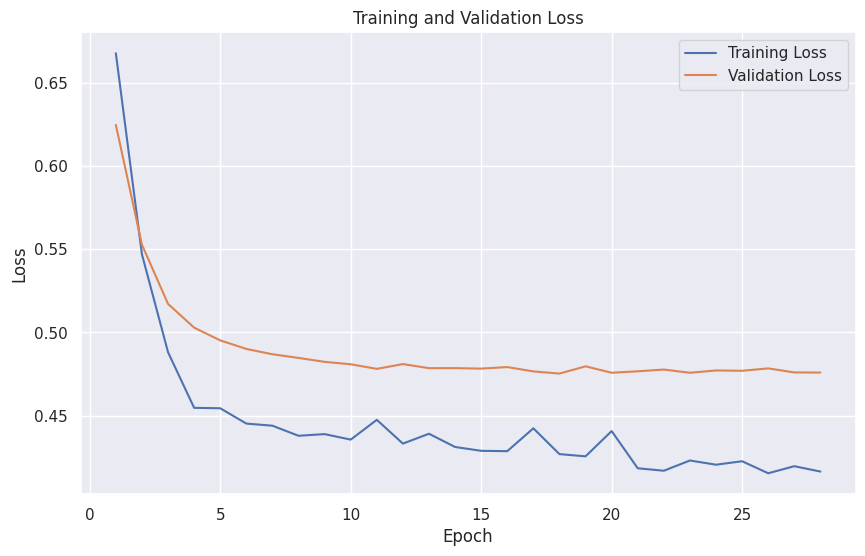

In [64]:
plt.figure(figsize=(10, 6))

train_loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [65]:
predicted = model_lstm.predict(X_test)
predicted = tf.squeeze(predicted)
predicted = np.array([1 if x >= 0.5 else 0 for x in predicted])
actual = np.array(y_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [66]:
predicted[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

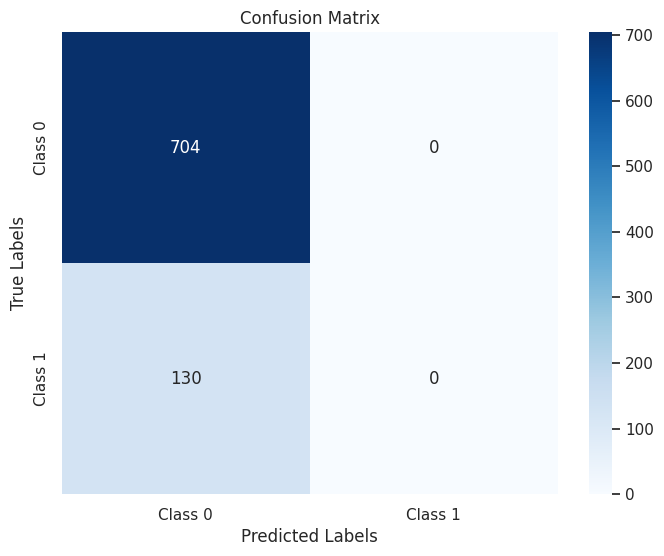

In [67]:
cm = confusion_matrix(y_test, predicted)

class_labels = ['Class 0', 'Class 1']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

As we observe, our LSTM model currently struggles to accurately identify true positive values without weight balancing. We have the option to enhance our model or utilize libraries like SMOTE to balance our data weights.

# <div style="border-radius:10px; border:#5E5772 solid; padding: 12px; background-color: #6999; font-size:100%; font-family:Comic Sans MS; font-family:Comic Sans MS; text-align:center"> LSTM-SMOTE-WEIGHTED </div>

## SMOTE

In [68]:
# SMOTE oversampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [69]:
X_train_resampled

,ACCOUNT LENGTH,INTERNATIONAL PLAN,VOICE MAIL PLAN,NUMBER VMAIL MESSAGES,TOTAL DAY MINUTES,TOTAL DAY CALLS,TOTAL DAY CHARGE,TOTAL EVE MINUTES,TOTAL EVE CALLS,TOTAL EVE CHARGE,TOTAL NIGHT MINUTES,TOTAL NIGHT CALLS,TOTAL NIGHT CHARGE,TOTAL INTL MINUTES,TOTAL INTL CALLS,TOTAL INTL CHARGE,CUSTOMER SERVICE CALLS,NEW_TOTALMINUTES,NEW_TOTALCHARGES,NEW_TOTALCALLS,NEW_AVGDAYCALLDURATION,NEW_AVGEVECALLDURATION,NEW_AVGNIGHTCALLDURATION,NEW_AVGINTLCHARGEPERMINUTE,NEW_AVGDAYCHARGEPERCALL,NEW_AVGEVECHARGEPERCALL,NEW_AVGNIGHTCHARGEPERCALL,NEW_AVGINTLCHARGEPERCALL,NEW_AVGVMAILCHARGEPERMESSAGE,NEW_AVGSERVICECALLCHARGE,AREA CODE_415,AREA CODE_510
0,0.483,0,1,0.765,0.261,0.758,0.261,0.605,0.665,0.605,0.554,0.465,0.554,0.635,0.400,0.635,0.222,0.441,0.339,0.671,0.098,0.109,0.302,0.417,0.099,0.109,0.303,0.076,0.064,0.130,1,0
1,0.496,0,1,0.549,0.314,0.570,0.314,0.389,0.447,0.389,0.576,0.380,0.576,0.320,0.150,0.320,0.222,0.355,0.295,0.311,0.159,0.104,0.363,0.469,0.159,0.104,0.363,0.107,0.109,0.157,0,1
2,0.331,0,0,0.000,0.926,0.291,0.926,0.650,0.482,0.650,0.442,0.317,0.442,0.655,0.250,0.656,0.000,0.787,0.878,0.090,0.936,0.170,0.316,0.450,0.936,0.170,0.316,0.134,0.186,0.342,1,0
3,0.174,0,1,0.686,0.571,0.636,0.571,0.672,0.518,0.672,0.495,0.451,0.495,0.580,0.200,0.580,0.333,0.626,0.608,0.459,0.262,0.163,0.277,0.362,0.262,0.163,0.277,0.149,0.160,0.190,0,0
4,0.508,0,0,0.000,0.508,0.618,0.508,0.646,0.706,0.646,0.582,0.606,0.583,0.545,0.050,0.544,0.333,0.628,0.566,0.689,0.240,0.110,0.259,0.339,0.240,0.110,0.259,0.594,0.186,0.169,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4287,0.323,0,0,0.000,0.433,0.441,0.433,0.478,0.592,0.478,0.486,0.626,0.487,0.598,0.138,0.598,0.534,0.423,0.411,0.484,0.287,0.095,0.209,0.406,0.287,0.095,0.209,0.283,0.186,0.091,0,0
4288,0.531,0,0,0.000,0.399,0.632,0.399,0.571,0.621,0.571,0.435,0.637,0.435,0.516,0.109,0.516,0.556,0.427,0.410,0.654,0.184,0.114,0.184,0.318,0.184,0.114,0.184,0.257,0.186,0.080,0,1
4289,0.414,1,0,0.000,0.724,0.423,0.724,0.545,0.620,0.545,0.593,0.477,0.593,0.802,0.226,0.803,0.057,0.699,0.703,0.396,0.501,0.107,0.324,0.469,0.501,0.107,0.324,0.186,0.186,0.484,1,0
4290,0.276,0,0,0.000,0.817,0.682,0.817,0.611,0.289,0.611,0.383,0.525,0.383,0.435,0.190,0.436,0.111,0.664,0.759,0.365,0.351,0.277,0.194,0.467,0.351,0.278,0.194,0.114,0.186,0.817,1,0


In [70]:
y_train_resampled

0       0
1       0
2       1
3       0
4       0
       ..
4287    1
4288    1
4289    1
4290    1
4291    1
Name: CHURN, Length: 4292, dtype: int64

In [71]:
model_lstm_smote = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(X_train.shape[1], 1), activation="tanh", 
                         return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.002)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.LSTM(64, activation="tanh", return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.LSTM(64, activation="tanh", return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.LSTM(2, activation="tanh", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(1, activation="sigmoid")])

model_lstm_smote.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True)

model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 2)              │           536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 448,595 (1.71 MB)

 Trainable params: 149,531 (584.11 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 299,064 (1.14 MB)

In [72]:
history_lstm = model_lstm_smote.fit(X_train_resampled, y_train_resampled,
                    validation_data=(X_test, y_test),
                    epochs=100,
                    batch_size=64,
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5105 - loss: 0.9037 - val_accuracy: 0.8441 - val_loss: 0.7406
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5004 - loss: 0.7380 - val_accuracy: 0.8465 - val_loss: 0.6938
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5335 - loss: 0.7024 - val_accuracy: 0.1619 - val_loss: 0.7326
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5785 - loss: 0.6878 - val_accuracy: 0.4676 - val_loss: 0.6922
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5941 - loss: 0.6835 - val_accuracy: 0.6295 - val_loss: 0.6149
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5823 - loss: 0.6791 - val_accuracy: 0.2482 - val_loss: 0.6818
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5892 - loss: 0.6801 - val_accuracy: 0.4173 - val_loss: 0.7036
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6142 - loss: 0.6656 - val_accuracy: 0.

In [73]:
loss_and_metrics = model_lstm_smote.evaluate(X_test, y_test)
print(loss_and_metrics)
print('Loss = ',loss_and_metrics[0])
print('Accuracy = ',loss_and_metrics[1])

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6386 - loss: 0.6155
[0.610734224319458, 0.6426858305931091]
Loss =  0.610734224319458
Accuracy =  0.6426858305931091


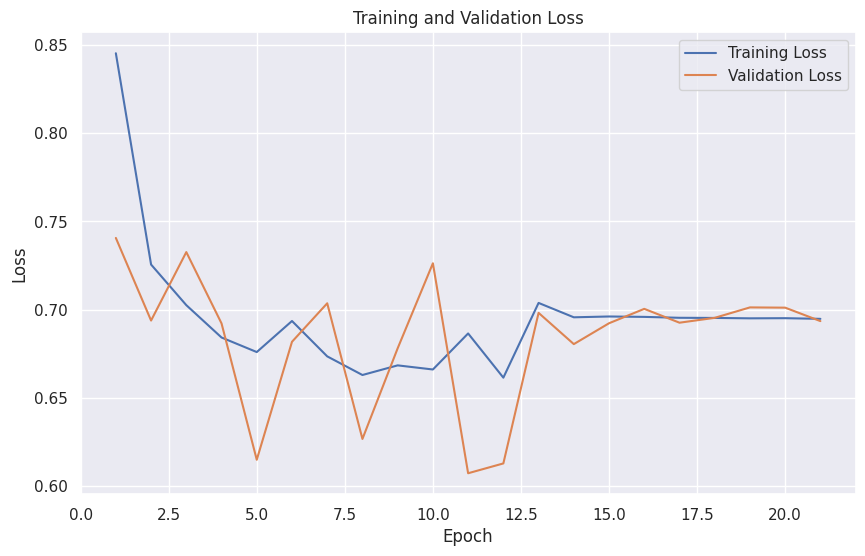

In [74]:
plt.figure(figsize=(10, 6))

train_loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [75]:
predicted = model_lstm.predict(X_test)
predicted = tf.squeeze(predicted)
predicted = np.array([1 if x >= 0.5 else 0 for x in predicted])
actual = np.array(y_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


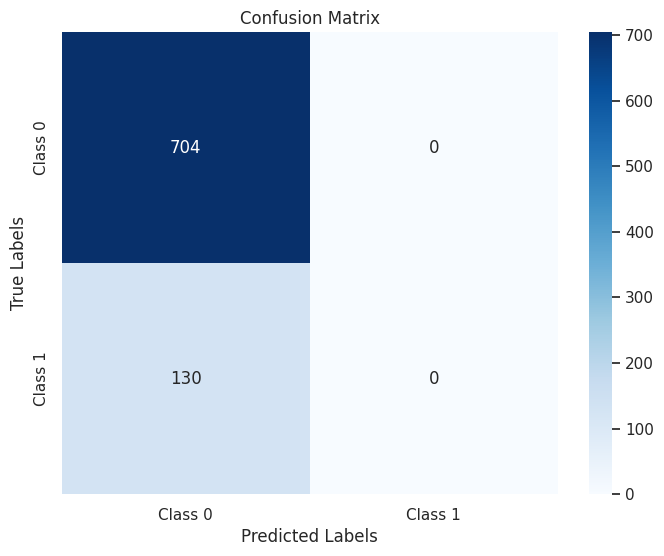

In [76]:
cm = confusion_matrix(y_test, predicted)

class_labels = ['Class 0', 'Class 1']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In my tries, I get some true positive values but it changes when I load my nb. Lets see what happen if we use weight balance method.

## WEIGHTED

In [77]:
model_lstm_weighted = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(X_train.shape[1], 1), activation="tanh", 
                         return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.002)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.LSTM(64, activation="tanh", return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.LSTM(64, activation="tanh", return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.LSTM(2, activation="tanh", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(1, activation="sigmoid")])

model_lstm_weighted.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True)

model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 2)              │           536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 448,595 (1.71 MB)

 Trainable params: 149,531 (584.11 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 299,064 (1.14 MB)

In [78]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.5822460391425909, 1: 3.539660056657224}


In [79]:
weighted_lstm = model_lstm_weighted.fit(X_train, y_train,
                            validation_data=(X_test, y_test),
                            epochs=100,
                            batch_size=64,
                            class_weight=class_weights_dict,
                            callbacks=[early_stopping],
                            verbose=1)

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.2732 - loss: 0.9605 - val_accuracy: 0.8441 - val_loss: 0.7902
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6681 - loss: 0.7800 - val_accuracy: 0.1559 - val_loss: 0.7428
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3354 - loss: 0.7315 - val_accuracy: 0.8441 - val_loss: 0.7109
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3222 - loss: 0.7138 - val_accuracy: 0.1559 - val_loss: 0.7051
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1623 - loss: 0.6932 - val_accuracy: 0.1571 - val_loss: 0.6986
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2717 - loss: 0.7135 - val_accuracy: 0.1559 - val_loss: 0.6976
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1541 - loss: 0.6895 - val_accuracy: 0.1559 - val_loss: 0.7004
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1550 - loss: 0.7037 - val_accuracy: 0.

In [80]:
loss_and_metrics = model_lstm.evaluate(X_test, y_test)
print(loss_and_metrics)
print('Loss = ',loss_and_metrics[0])
print('Accuracy = ',loss_and_metrics[1])

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8435 - loss: 0.4388
[0.455884724855423, 0.8441246747970581]
Loss =  0.455884724855423
Accuracy =  0.8441246747970581


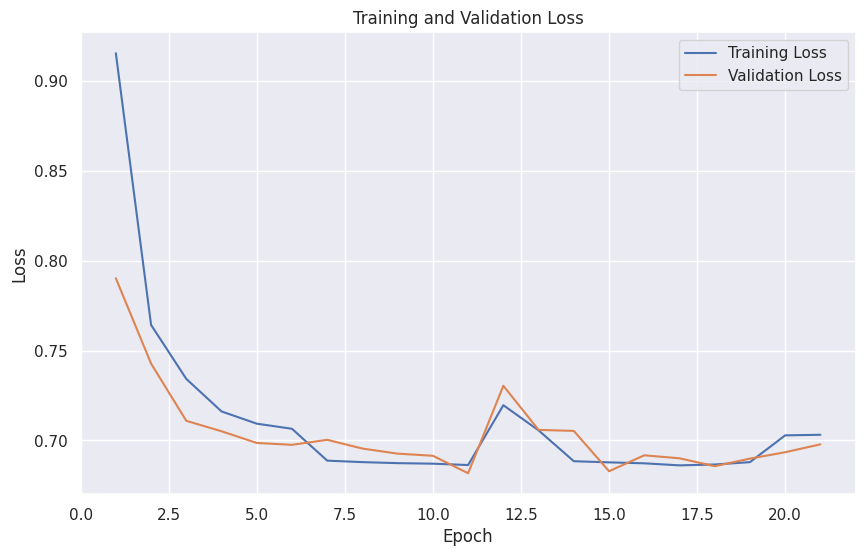

In [81]:
plt.figure(figsize=(10, 6))

train_loss = weighted_lstm.history['loss']
val_loss = weighted_lstm.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [82]:
predicted = model_lstm_weighted.predict(X_test)
predicted = tf.squeeze(predicted)
predicted = np.array([1 if x >= 0.5 else 0 for x in predicted])
actual = np.array(y_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


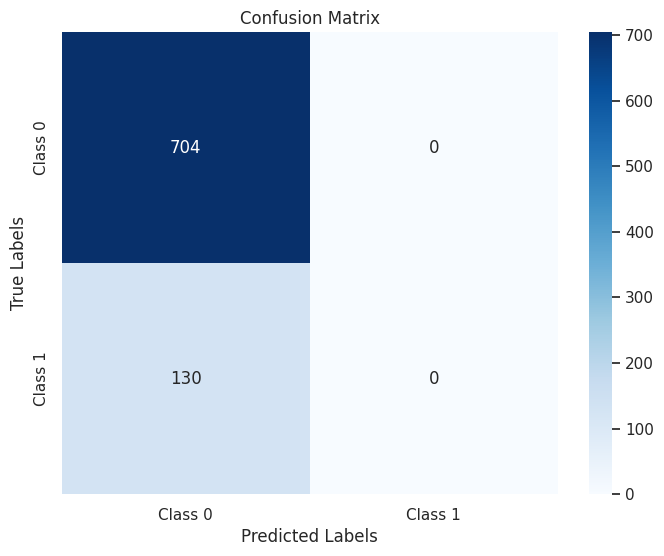

In [83]:
cm = confusion_matrix(y_test, predicted)

class_labels = ['Class 0', 'Class 1']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# CONCLUSION



In my churn model, I achieved the best results with CatBoost compared to models like LGBM, ANN, and LSTM. You can potentially improve results by experimenting with different hyperparameter values or exploring alternative sets of hyperparameters.

If you have any feedback on my work, I'm eager to discuss any mistakes with you. Please feel free to share your comments openly.